In [1]:
# Installs

#!pip install import_ipynb

#!pip install albumentations
#!pip install --upgrade albumentations
#!pip show albumentations

#!pip install segmentation-models-pytorch
#!pip install --upgrade segmentation-models-pytorch

In [2]:
# Standard library imports
import os 
import csv

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm  # Import tqdm for progress visualization

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary  # for printing model summary
from torch.utils.data import Dataset, DataLoader

# Albumentations imports
import albumentations as A  # Import Albumentations
from albumentations import Compose as AlbCompose, Resize as AlbResize, Normalize as AlbNormalize


from albumentations.pytorch import ToTensorV2

# Segmentation models imports
from segmentation_models_pytorch import DeepLabV3Plus

# Scikit-learn metrics imports
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

# Other torchvision transforms
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms



c:\Users\ssrir\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class DeepLabV3PlusWithSigmoid(nn.Module):
    def __init__(self, encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=2):
        super(DeepLabV3PlusWithSigmoid, self).__init__()
        self.model = DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x

#load the model
def load_initial_model_state(model, filepath='initial_deeplab_model.pth'):
    model.load_state_dict(torch.load(filepath, weights_only=True))
    model.eval()  # Set the model to evaluation mode
    model.to(device) # Move the model to the device
    print("initial_deeplab_model.pth loaded successfully!")



# Training setup
# num_epochs = 5  # use for testing the code.
num_epochs = 50  # normally 50 epochs
learning_rate = 0.001
improvement_tolerance = 0.0001  # Minimum improvement required to reset the counter
# improvement_tolerance = 0.00001  # Use this for the final run of the model on Google Colab ????
patience = 3 # Number of epochs to wait for improvement before early stopping
# patience = 5 # Use this for final run of the model on Google Colab ????
criterion = nn.CrossEntropyLoss()

# Initialize metric lists to store the results.
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
train_jaccards, test_jaccards = [], []
train_precisions, test_precisions = [], []
train_recalls, test_recalls = [], []
train_dices, test_dices = [], []


# Function to get transforms for specified resolution (64x64, 128x128, 256x256)
resolutions = [(64, 64), (128, 128), (256, 256)]

# Adapted set_resolution function for KvasirDataset
def set_resolution(dataset, resolution):
    """Modifies the dataset transformation to resize images to the specified resolution."""
    transform = transforms.Compose([
        transforms.Resize(resolution),
        transforms.ToTensor(),
    ])
    dataset.transform = transform  # Set the new transform for the dataset
    return dataset


# Define reset_weights function
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()  # This resets the model's weights

# Function to initialize CSV with headers
def initialize_csv(filename, resolution):
    headers = [
        "Resolution", "Epoch", "Train Loss", "Train Accuracy", "Train Jaccard", 
        "Train Precision", "Train Recall", "Train Dice",
        "Test Loss", "Test Accuracy", "Test Jaccard", 
        "Test Precision", "Test Recall", "Test Dice"
    ]
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)

# Log metrics to CSV
def log_metrics_to_csv(filename, resolution, epoch, metrics):
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            resolution, epoch,
            metrics["train_loss"], metrics["train_acc"], metrics["train_jaccard"], 
            metrics["train_precision"], metrics["train_recall"], metrics["train_dice"],
            metrics["test_loss"], metrics["test_acc"], metrics["test_jaccard"], 
            metrics["test_precision"], metrics["test_recall"], metrics["test_dice"]
        ])
        
# Dataset Class
class KvasirDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        with open(file_list, 'r') as f:
            self.image_filenames = f.read().splitlines()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.images_dir, self.image_filenames[idx] + '.jpg')).convert("RGB")
        mask = Image.open(os.path.join(self.masks_dir, self.image_filenames[idx] + '.png')).convert("L")

        # Convert images to numpy arrays
        image_np = np.array(image)
        mask_np = np.array(mask)

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)  # Use the correct keyword arguments
            image, mask = augmented['image'], augmented['mask']

        mask = (mask > 0).astype(np.int64)  # Convert mask to binary (0 or 1)

        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Change shape to C x H x W
        mask = torch.tensor(mask, dtype=torch.long)  # Keep mask as long for class indices

        return image, mask



# Data transformations
def get_transforms(resolution=(256, 256)):  # Add resolution as a parameter
    return AlbCompose([
        AlbResize(height=resolution[0], width=resolution[1], interpolation=1),  # Use resolution from argument
        AlbNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])

# Iterate over different resolutions
for res in resolutions:
    resolution_str = f"{res[0]}x{res[1]}"
    print(f"\n--- Preparing images with resolution: {resolution_str} ---")

    # Get transforms for the current resolution
    train_transforms = get_transforms(resolution=res)  # Pass the tuple directly
    test_transforms = get_transforms(resolution=res)   # Pass the tuple directly

    # Load datasets with the specified transforms
    print(f"Loading training dataset at resolution {resolution_str}...")
    train_dataset = KvasirDataset('kvasir-instrument/images/', 'kvasir-instrument/masks/', 'kvasir-instrument/train.txt', transform=train_transforms)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

    print(f"Loading testing dataset at resolution {resolution_str}...")
    test_dataset = KvasirDataset('kvasir-instrument/images/', 'kvasir-instrument/masks/', 'kvasir-instrument/test.txt', transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    
    print("Data loaders for training and testing initialized.\n")


# Evaluation function
def calculate_accuracy(preds, targets):
    correct = (preds == targets).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy

def calculate_metrics(preds, targets):
    """Calculate Jaccard, Precision, Recall, Accuracy, and Dice Coefficient for binary classification."""
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    jaccard = jaccard_score(targets_flat, preds_flat, average='binary')
    precision = precision_score(targets_flat, preds_flat, zero_division=0)
    recall = recall_score(targets_flat, preds_flat, zero_division=0)
    accuracy = (preds_flat == targets_flat).sum() / len(targets_flat)

    # Dice Coefficient as F1 Score in binary case
    dice = f1_score(targets_flat, preds_flat, average='binary')

    return jaccard, precision, recall, accuracy, dice





--- Preparing images with resolution: 64x64 ---
Loading training dataset at resolution 64x64...
Loading testing dataset at resolution 64x64...
Data loaders for training and testing initialized.


--- Preparing images with resolution: 128x128 ---
Loading training dataset at resolution 128x128...
Loading testing dataset at resolution 128x128...
Data loaders for training and testing initialized.


--- Preparing images with resolution: 256x256 ---
Loading training dataset at resolution 256x256...
Loading testing dataset at resolution 256x256...
Data loaders for training and testing initialized.



In [4]:
# Initialize CSV file with headers
csv_filename = "experiment01_results_metrics.csv"
initialize_csv(csv_filename, resolution=None)  # Pass resolution if needed

# Training function with logging to CSV
def train_and_evaluate(model, train_loader, test_loader, csv_filename, resolution):
    best_test_loss = float('inf')
    early_stop_counter = 0

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_acc = 0.0, 0.0
        all_train_jaccard, all_train_precision, all_train_recall, all_train_dice = [], [], [], []

        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            running_loss += loss.item()
            running_acc += calculate_accuracy(preds, masks).item()

            # Calculate training metrics
            jaccard, precision, recall, _, dice = calculate_metrics(preds.cpu().numpy(), masks.cpu().numpy())
            all_train_jaccard.append(jaccard)
            all_train_precision.append(precision)
            all_train_recall.append(recall)
            all_train_dice.append(dice)

        # Log training metrics
        avg_train_loss = running_loss / len(train_loader)
        avg_train_acc = running_acc / len(train_loader)
        avg_train_jaccard = sum(all_train_jaccard) / len(all_train_jaccard)
        avg_train_precision = sum(all_train_precision) / len(all_train_precision)
        avg_train_recall = sum(all_train_recall) / len(all_train_recall)
        avg_train_dice = sum(all_train_dice) / len(all_train_dice)

        # Validation/Test Step
        model.eval()
        with torch.no_grad():
            running_test_loss, running_test_acc = 0.0, 0.0
            all_jaccard, all_precision, all_recall, all_accuracy, all_dice = [], [], [], [], []

            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                test_loss = criterion(outputs, masks)
                running_test_loss += test_loss.item()

                preds = torch.argmax(outputs, dim=1)
                jaccard, precision, recall, accuracy, dice = calculate_metrics(preds.cpu().numpy(), masks.cpu().numpy())
                all_jaccard.append(jaccard)
                all_precision.append(precision)
                all_recall.append(recall)
                all_accuracy.append(accuracy)
                all_dice.append(dice)

            # Average metrics
            avg_test_loss = running_test_loss / len(test_loader)
            avg_test_acc = sum(all_accuracy) / len(all_accuracy)
            avg_jaccard = sum(all_jaccard) / len(all_jaccard)
            avg_precision = sum(all_precision) / len(all_precision)
            avg_recall = sum(all_recall) / len(all_recall)
            avg_dice = sum(all_dice) / len(all_dice)

            # Print metrics after each epoch
            print(f"Epoch [{epoch + 1}/{num_epochs}]:")
            print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")
            print(f"  Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")

            # Save metrics to CSV
            log_metrics_to_csv(csv_filename, resolution, epoch, {
                "train_loss": avg_train_loss,
                "train_acc": avg_train_acc,
                "train_jaccard": avg_train_jaccard,
                "train_precision": avg_train_precision,
                "train_recall": avg_train_recall,
                "train_dice": avg_train_dice,
                "test_loss": avg_test_loss,
                "test_acc": avg_test_acc,
                "test_jaccard": avg_jaccard,
                "test_precision": avg_precision,
                "test_recall": avg_recall,
                "test_dice": avg_dice
            })

            # Early stopping logic
            if avg_test_loss < best_test_loss - improvement_tolerance:
                best_test_loss = avg_test_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1} due to lack of improvement.")
                    break

        scheduler.step()

# Use the function in a loop for each resolution
for res in resolutions:
    resolution_str = f"{res[0]}x{res[1]}"
    print(f"\n--- Training with resolution: {resolution_str} ---")
    
    # Load datasets with specific resolution
    train_transforms = get_transforms(resolution=res)
    test_transforms = get_transforms(resolution=res)
    
    train_dataset = KvasirDataset('kvasir-instrument/images/', 'kvasir-instrument/masks/', 'kvasir-instrument/train.txt', transform=train_transforms)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    
    test_dataset = KvasirDataset('kvasir-instrument/images/', 'kvasir-instrument/masks/', 'kvasir-instrument/test.txt', transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Initialize and reset model weights for each resolution
    model = DeepLabV3PlusWithSigmoid().to(device)
    model.apply(reset_weights)
    
    # Run training and evaluation
    train_and_evaluate(model, train_loader, test_loader, csv_filename, resolution_str)



--- Training with resolution: 64x64 ---


Epoch 1/50: 100%|██████████| 59/59 [00:28<00:00,  2.08it/s]


Epoch [1/50]:
  Train Loss: 0.4395, Train Accuracy: 0.9171
  Test Loss: 0.3701, Test Accuracy: 0.9463


Epoch 2/50: 100%|██████████| 59/59 [00:32<00:00,  1.82it/s]


Epoch [2/50]:
  Train Loss: 0.3647, Train Accuracy: 0.9546
  Test Loss: 0.3553, Test Accuracy: 0.9631


Epoch 3/50: 100%|██████████| 59/59 [00:29<00:00,  2.01it/s]


Epoch [3/50]:
  Train Loss: 0.3579, Train Accuracy: 0.9575
  Test Loss: 0.3853, Test Accuracy: 0.9293


Epoch 4/50: 100%|██████████| 59/59 [00:31<00:00,  1.86it/s]


Epoch [4/50]:
  Train Loss: 0.3538, Train Accuracy: 0.9599
  Test Loss: 0.3466, Test Accuracy: 0.9665


Epoch 5/50: 100%|██████████| 59/59 [00:30<00:00,  1.94it/s]


Epoch [5/50]:
  Train Loss: 0.3465, Train Accuracy: 0.9672
  Test Loss: 0.3417, Test Accuracy: 0.9712


Epoch 6/50: 100%|██████████| 59/59 [00:29<00:00,  1.99it/s]


Epoch [6/50]:
  Train Loss: 0.3451, Train Accuracy: 0.9682
  Test Loss: 0.3427, Test Accuracy: 0.9708


Epoch 7/50: 100%|██████████| 59/59 [00:30<00:00,  1.93it/s]


Epoch [7/50]:
  Train Loss: 0.3451, Train Accuracy: 0.9678
  Test Loss: 0.3477, Test Accuracy: 0.9650


Epoch 8/50: 100%|██████████| 59/59 [00:29<00:00,  1.99it/s]


Epoch [8/50]:
  Train Loss: 0.3397, Train Accuracy: 0.9737
  Test Loss: 0.3364, Test Accuracy: 0.9770


Epoch 9/50: 100%|██████████| 59/59 [00:29<00:00,  1.97it/s]


Epoch [9/50]:
  Train Loss: 0.3372, Train Accuracy: 0.9764
  Test Loss: 0.3362, Test Accuracy: 0.9772


Epoch 10/50: 100%|██████████| 59/59 [00:30<00:00,  1.96it/s]


Epoch [10/50]:
  Train Loss: 0.3372, Train Accuracy: 0.9762
  Test Loss: 0.3357, Test Accuracy: 0.9777


Epoch 11/50: 100%|██████████| 59/59 [00:30<00:00,  1.96it/s]


Epoch [11/50]:
  Train Loss: 0.3364, Train Accuracy: 0.9773
  Test Loss: 0.3368, Test Accuracy: 0.9764


Epoch 12/50: 100%|██████████| 59/59 [00:30<00:00,  1.92it/s]


Epoch [12/50]:
  Train Loss: 0.3360, Train Accuracy: 0.9776
  Test Loss: 0.3356, Test Accuracy: 0.9778


Epoch 13/50: 100%|██████████| 59/59 [00:31<00:00,  1.87it/s]


Epoch [13/50]:
  Train Loss: 0.3354, Train Accuracy: 0.9782
  Test Loss: 0.3358, Test Accuracy: 0.9776


Epoch 14/50: 100%|██████████| 59/59 [00:35<00:00,  1.65it/s]


Epoch [14/50]:
  Train Loss: 0.3350, Train Accuracy: 0.9788
  Test Loss: 0.3346, Test Accuracy: 0.9788


Epoch 15/50: 100%|██████████| 59/59 [00:33<00:00,  1.74it/s]


Epoch [15/50]:
  Train Loss: 0.3345, Train Accuracy: 0.9793
  Test Loss: 0.3357, Test Accuracy: 0.9776


Epoch 16/50: 100%|██████████| 59/59 [00:34<00:00,  1.73it/s]


Epoch [16/50]:
  Train Loss: 0.3340, Train Accuracy: 0.9798
  Test Loss: 0.3346, Test Accuracy: 0.9788


Epoch 17/50: 100%|██████████| 59/59 [00:32<00:00,  1.81it/s]


Epoch [17/50]:
  Train Loss: 0.3338, Train Accuracy: 0.9799
  Test Loss: 0.3364, Test Accuracy: 0.9770
Early stopping at epoch 17 due to lack of improvement.

--- Training with resolution: 128x128 ---


Epoch 1/50: 100%|██████████| 59/59 [01:01<00:00,  1.04s/it]


Epoch [1/50]:
  Train Loss: 0.4435, Train Accuracy: 0.9011
  Test Loss: 0.3730, Test Accuracy: 0.9444


Epoch 2/50: 100%|██████████| 59/59 [00:56<00:00,  1.04it/s]


Epoch [2/50]:
  Train Loss: 0.3715, Train Accuracy: 0.9452
  Test Loss: 0.3807, Test Accuracy: 0.9335


Epoch 3/50: 100%|██████████| 59/59 [00:57<00:00,  1.02it/s]


Epoch [3/50]:
  Train Loss: 0.3587, Train Accuracy: 0.9556
  Test Loss: 0.3599, Test Accuracy: 0.9509


Epoch 4/50: 100%|██████████| 59/59 [00:58<00:00,  1.01it/s]


Epoch [4/50]:
  Train Loss: 0.3530, Train Accuracy: 0.9603
  Test Loss: 0.3750, Test Accuracy: 0.9368


Epoch 5/50: 100%|██████████| 59/59 [00:57<00:00,  1.03it/s]


Epoch [5/50]:
  Train Loss: 0.3488, Train Accuracy: 0.9641
  Test Loss: 0.3523, Test Accuracy: 0.9598


Epoch 6/50: 100%|██████████| 59/59 [00:56<00:00,  1.05it/s]


Epoch [6/50]:
  Train Loss: 0.3465, Train Accuracy: 0.9664
  Test Loss: 0.3415, Test Accuracy: 0.9715


Epoch 7/50: 100%|██████████| 59/59 [00:55<00:00,  1.07it/s]


Epoch [7/50]:
  Train Loss: 0.3436, Train Accuracy: 0.9691
  Test Loss: 0.3356, Test Accuracy: 0.9777


Epoch 8/50: 100%|██████████| 59/59 [00:56<00:00,  1.05it/s]


Epoch [8/50]:
  Train Loss: 0.3387, Train Accuracy: 0.9743
  Test Loss: 0.3323, Test Accuracy: 0.9810


Epoch 9/50: 100%|██████████| 59/59 [00:54<00:00,  1.07it/s]


Epoch [9/50]:
  Train Loss: 0.3369, Train Accuracy: 0.9764
  Test Loss: 0.3326, Test Accuracy: 0.9808


Epoch 10/50: 100%|██████████| 59/59 [00:55<00:00,  1.07it/s]


Epoch [10/50]:
  Train Loss: 0.3370, Train Accuracy: 0.9761
  Test Loss: 0.3315, Test Accuracy: 0.9819


Epoch 11/50: 100%|██████████| 59/59 [00:56<00:00,  1.04it/s]


Epoch [11/50]:
  Train Loss: 0.3359, Train Accuracy: 0.9773
  Test Loss: 0.3328, Test Accuracy: 0.9803


Epoch 12/50: 100%|██████████| 59/59 [00:55<00:00,  1.06it/s]


Epoch [12/50]:
  Train Loss: 0.3356, Train Accuracy: 0.9777
  Test Loss: 0.3324, Test Accuracy: 0.9807


Epoch 13/50: 100%|██████████| 59/59 [00:58<00:00,  1.01it/s]


Epoch [13/50]:
  Train Loss: 0.3353, Train Accuracy: 0.9779
  Test Loss: 0.3318, Test Accuracy: 0.9815
Early stopping at epoch 13 due to lack of improvement.

--- Training with resolution: 256x256 ---


Epoch 1/50: 100%|██████████| 59/59 [02:43<00:00,  2.77s/it]


Epoch [1/50]:
  Train Loss: 0.4487, Train Accuracy: 0.9010
  Test Loss: 0.3663, Test Accuracy: 0.9498


Epoch 2/50: 100%|██████████| 59/59 [02:43<00:00,  2.77s/it]


Epoch [2/50]:
  Train Loss: 0.3644, Train Accuracy: 0.9532
  Test Loss: 0.5664, Test Accuracy: 0.7334


Epoch 3/50: 100%|██████████| 59/59 [02:42<00:00,  2.76s/it]


Epoch [3/50]:
  Train Loss: 0.3588, Train Accuracy: 0.9554
  Test Loss: 0.3568, Test Accuracy: 0.9572


Epoch 4/50: 100%|██████████| 59/59 [02:40<00:00,  2.72s/it]


Epoch [4/50]:
  Train Loss: 0.3489, Train Accuracy: 0.9649
  Test Loss: 0.3483, Test Accuracy: 0.9641


Epoch 5/50: 100%|██████████| 59/59 [02:44<00:00,  2.79s/it]


Epoch [5/50]:
  Train Loss: 0.3462, Train Accuracy: 0.9670
  Test Loss: 0.3449, Test Accuracy: 0.9677


Epoch 6/50: 100%|██████████| 59/59 [02:44<00:00,  2.80s/it]


Epoch [6/50]:
  Train Loss: 0.3470, Train Accuracy: 0.9657
  Test Loss: 0.3359, Test Accuracy: 0.9778


Epoch 7/50: 100%|██████████| 59/59 [02:44<00:00,  2.80s/it]


Epoch [7/50]:
  Train Loss: 0.3422, Train Accuracy: 0.9706
  Test Loss: 0.3358, Test Accuracy: 0.9777


Epoch 8/50: 100%|██████████| 59/59 [02:44<00:00,  2.80s/it]


Epoch [8/50]:
  Train Loss: 0.3387, Train Accuracy: 0.9742
  Test Loss: 0.3315, Test Accuracy: 0.9819


Epoch 9/50: 100%|██████████| 59/59 [03:15<00:00,  3.32s/it]


Epoch [9/50]:
  Train Loss: 0.3365, Train Accuracy: 0.9766
  Test Loss: 0.3310, Test Accuracy: 0.9824


Epoch 10/50: 100%|██████████| 59/59 [03:49<00:00,  3.89s/it]


Epoch [10/50]:
  Train Loss: 0.3342, Train Accuracy: 0.9791
  Test Loss: 0.3309, Test Accuracy: 0.9824


Epoch 11/50: 100%|██████████| 59/59 [03:47<00:00,  3.85s/it]


Epoch [11/50]:
  Train Loss: 0.3333, Train Accuracy: 0.9800
  Test Loss: 0.3326, Test Accuracy: 0.9806


Epoch 12/50: 100%|██████████| 59/59 [03:20<00:00,  3.40s/it]


Epoch [12/50]:
  Train Loss: 0.3332, Train Accuracy: 0.9802
  Test Loss: 0.3302, Test Accuracy: 0.9831


Epoch 13/50: 100%|██████████| 59/59 [03:41<00:00,  3.76s/it]


Epoch [13/50]:
  Train Loss: 0.3331, Train Accuracy: 0.9801
  Test Loss: 0.3296, Test Accuracy: 0.9837


Epoch 14/50: 100%|██████████| 59/59 [04:07<00:00,  4.19s/it]


Epoch [14/50]:
  Train Loss: 0.3329, Train Accuracy: 0.9803
  Test Loss: 0.3293, Test Accuracy: 0.9840


Epoch 15/50: 100%|██████████| 59/59 [04:14<00:00,  4.31s/it]


Epoch [15/50]:
  Train Loss: 0.3320, Train Accuracy: 0.9814
  Test Loss: 0.3298, Test Accuracy: 0.9835


Epoch 16/50: 100%|██████████| 59/59 [04:17<00:00,  4.37s/it]


Epoch [16/50]:
  Train Loss: 0.3314, Train Accuracy: 0.9820
  Test Loss: 0.3298, Test Accuracy: 0.9834


Epoch 17/50: 100%|██████████| 59/59 [04:01<00:00,  4.10s/it]


Epoch [17/50]:
  Train Loss: 0.3313, Train Accuracy: 0.9822
  Test Loss: 0.3297, Test Accuracy: 0.9836
Early stopping at epoch 17 due to lack of improvement.


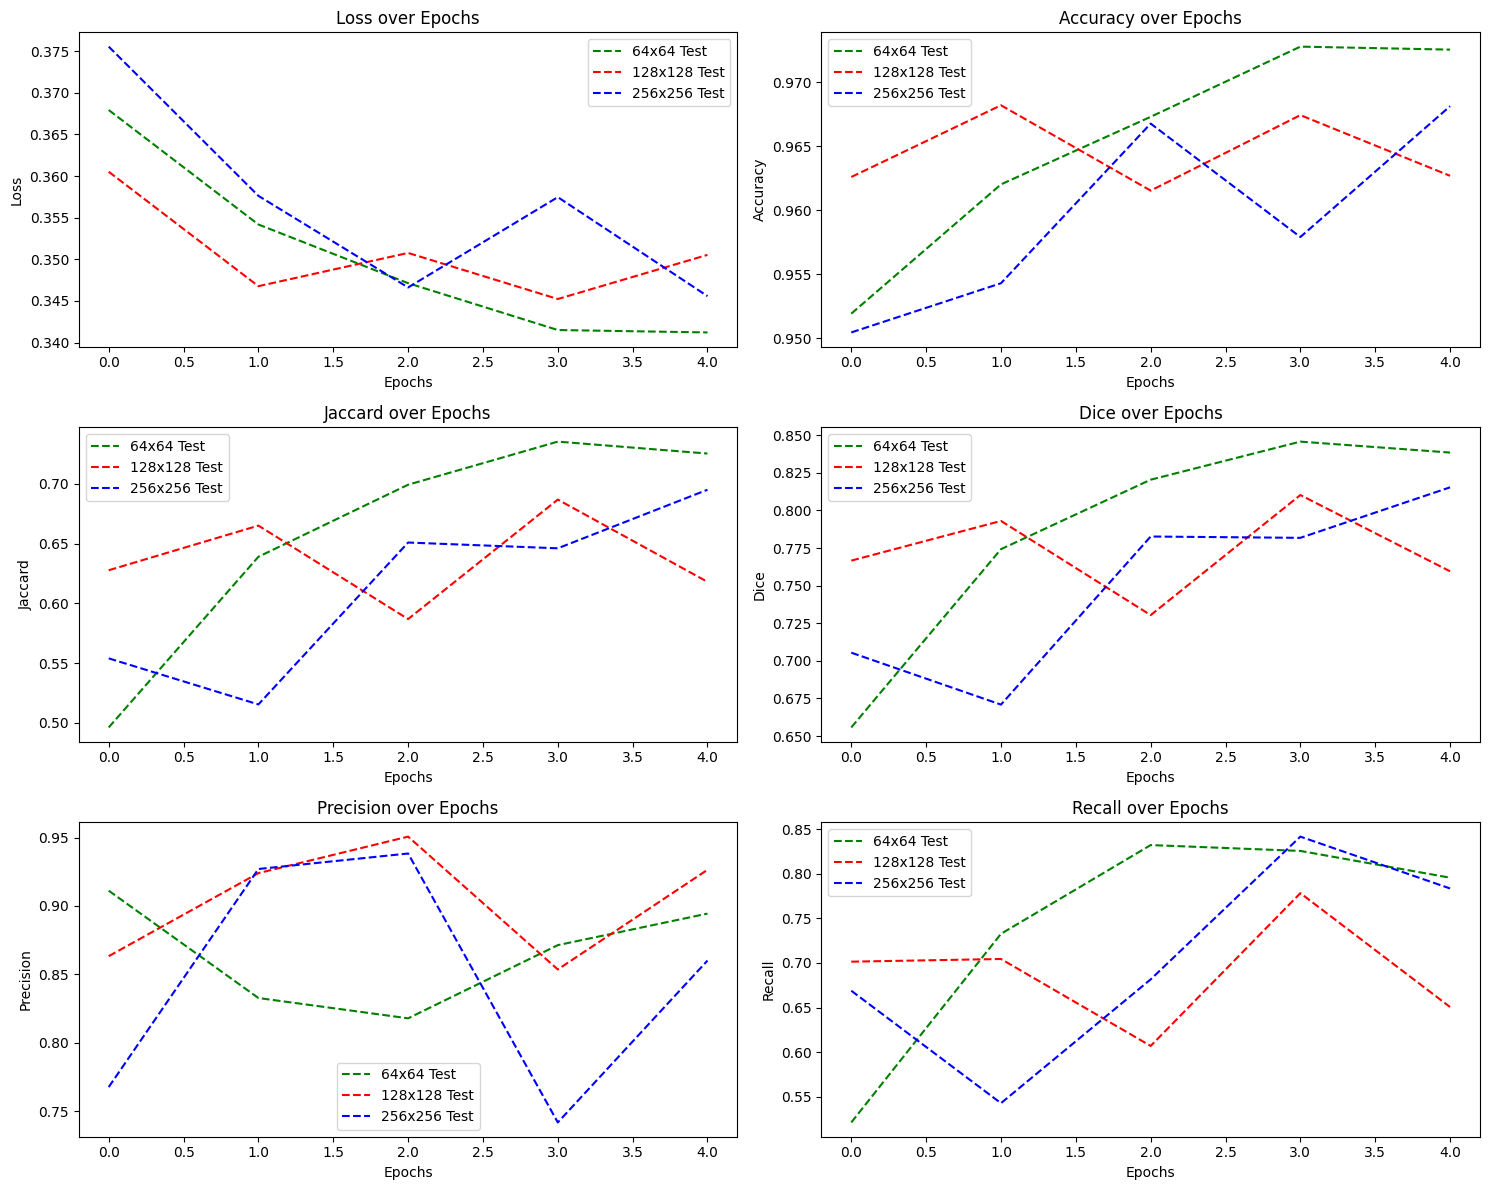

In [5]:

# Function to plot the metrics


# load the csv file
df = pd.read_csv('training_metrics.csv')

# Find the maximum epoch for each resolution
max_epochs_by_resolution = df.groupby('Resolution')['Epoch'].max()


def plot_metrics(df):
    # Extract unique resolutions
    resolutions = df['Resolution'].unique()
    
    # Create a figure with 6 subplots (one for each metric)
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # 3 rows, 2 columns
    colors = ['green', 'red', 'blue', 'orange']  # Use 4 distinct colors

    # List of metrics to plot
    metrics = ['Loss', 'Accuracy', 'Jaccard', 'Dice', 'Precision', 'Recall']
    metric_columns = [
        ('Train Loss', 'Test Loss'),
        ('Train Accuracy', 'Test Accuracy'),
        ('Train Jaccard', 'Test Jaccard'),
        ('Train Dice', 'Test Dice'),
        ('Train Precision', 'Test Precision'),
        ('Train Recall', 'Test Recall')
    ]
    
    # Iterate over each metric and plot
    for i, (metric, (train_col, test_col)) in enumerate(zip(metrics, metric_columns)):
        row = i // 2  # Determine row position (0, 1, or 2)
        col = i % 2   # Determine column position (0 or 1)

        # Plot data for each resolution with different colors
        for j, resolution in enumerate(resolutions):
            res_df = df[df['Resolution'] == resolution]
            epochs = res_df['Epoch']
            
            # Plot Training and Testing data
            # axes[row, col].plot(epochs, res_df[train_col], label=f'{resolution} Train', color=colors[j])
            axes[row, col].plot(epochs, res_df[test_col], label=f'{resolution} Test', color=colors[j], linestyle='--')
        
        axes[row, col].set_title(f'{metric} over Epochs')
        axes[row, col].set_xlabel('Epochs')
        axes[row, col].set_ylabel(metric)
        axes[row, col].legend()

    plt.tight_layout()
    plt.show()

# Call the plot_metrics function with the combined dataframe
plot_metrics(df)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


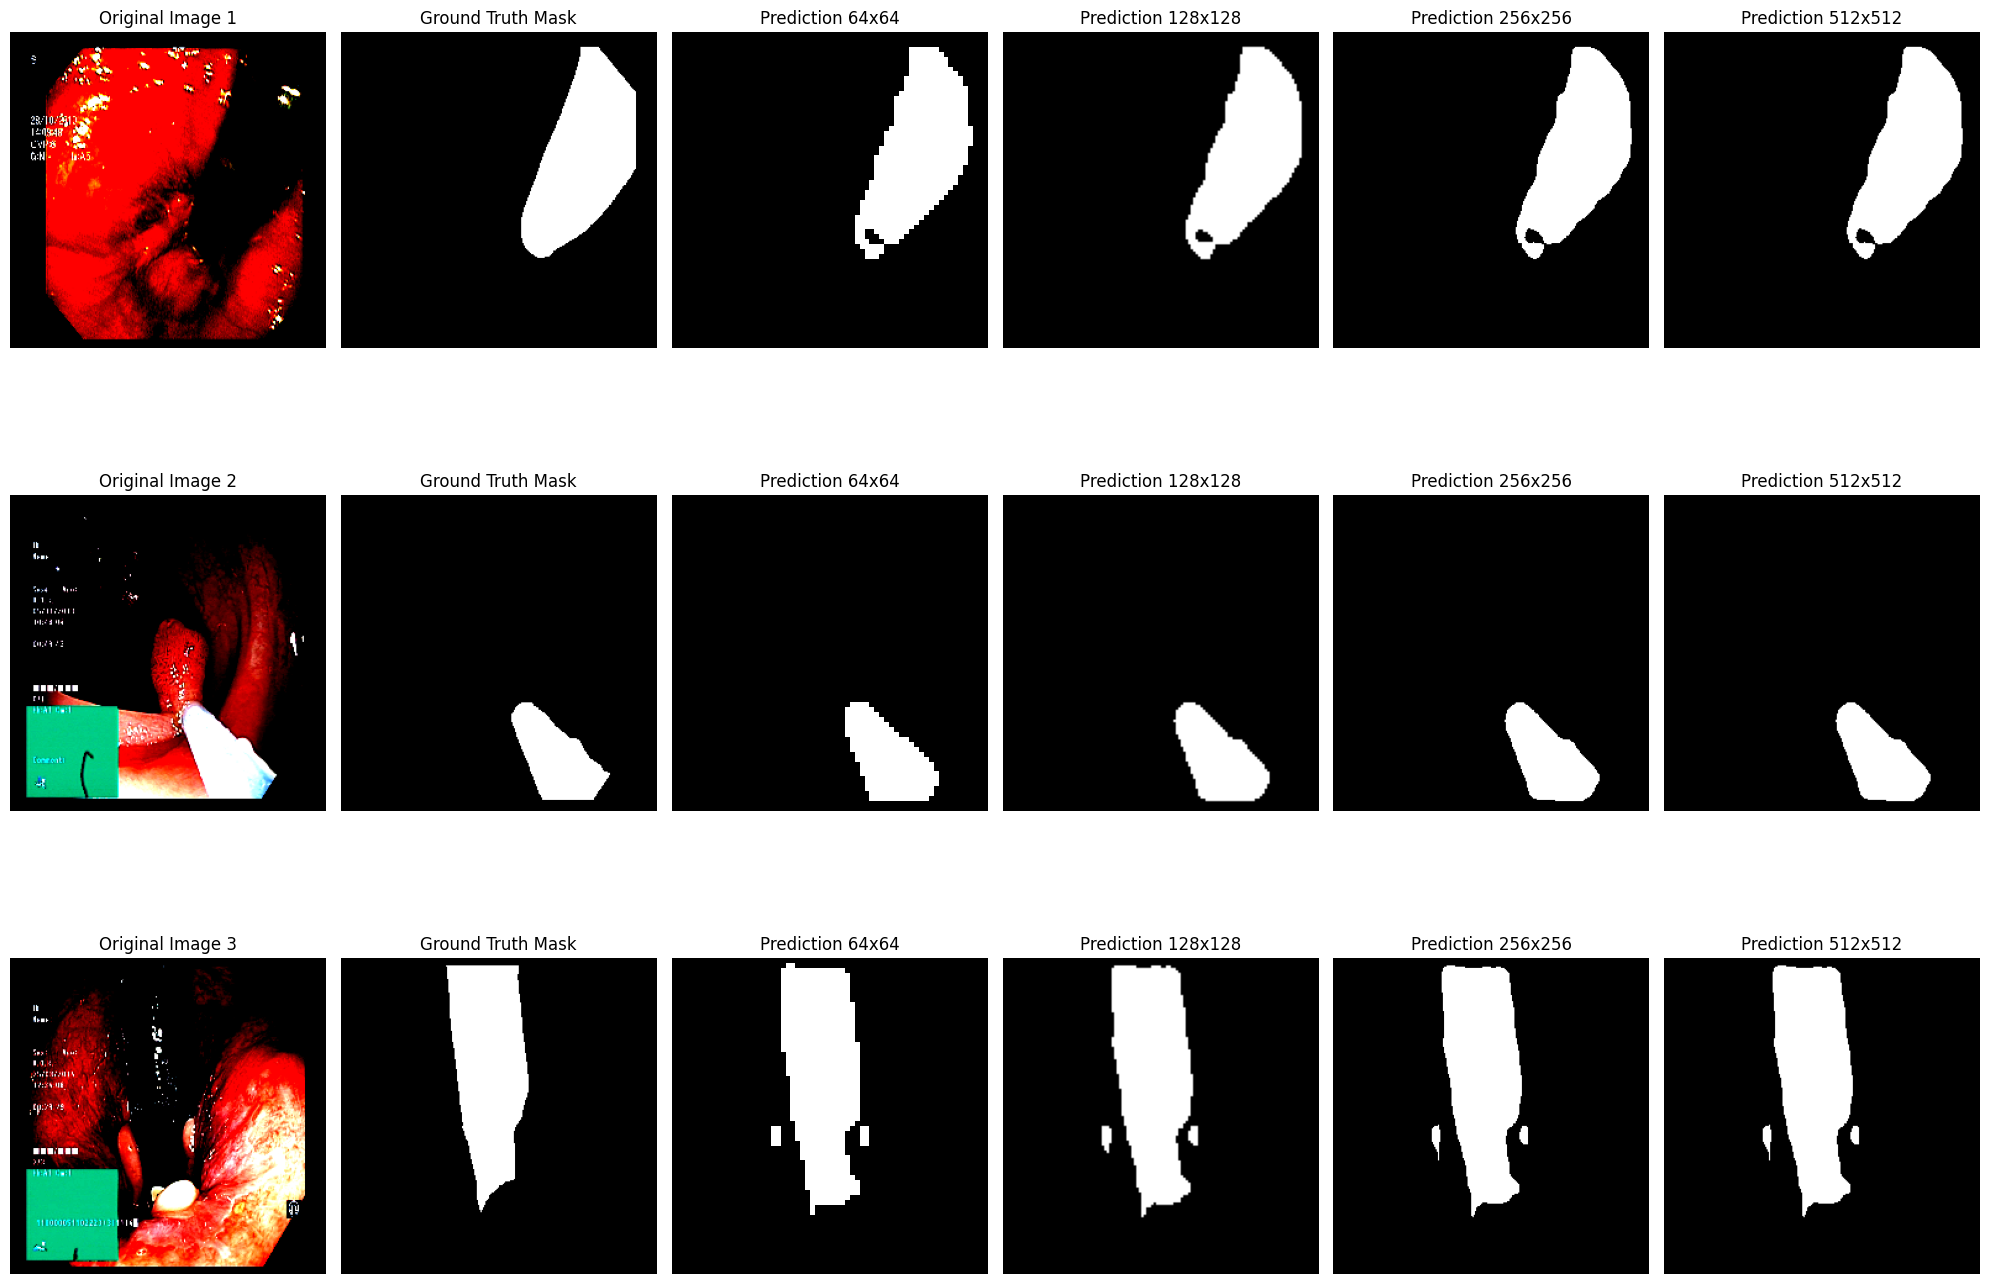

In [6]:
# Visualize the precisiton of the predictions
# Visualize the predictions at different resolutions

# Function to visualize images with ground truth and predictions at multiple resolutions

def visualize_images_with_predictions(images, masks, predictions, resolutions=[64, 128, 256, 512]):
    """
    Displays multiple images, their ground truth masks, and predicted masks at different resolutions.
    """
    num_images = len(images)
    num_resolutions = len(resolutions)

    # Create a figure with num_images rows and num_resolutions + 2 columns (1 for original, 1 for GT, and multiple for predictions)
    fig, axes = plt.subplots(num_images, num_resolutions + 2, figsize=(20, 5 * num_images))

    for img_idx in range(num_images):
        # Display the original image in the first column
        axes[img_idx, 0].imshow(images[img_idx])
        axes[img_idx, 0].set_title(f'Original Image {img_idx + 1}')
        axes[img_idx, 0].axis('off')

        # Display the ground truth mask in the second column
        axes[img_idx, 1].imshow(masks[img_idx].cpu().numpy(), cmap='gray')
        axes[img_idx, 1].set_title('Ground Truth Mask')
        axes[img_idx, 1].axis('off')

        for res_idx, res in enumerate(resolutions):
            # Resize the predicted mask
            resize_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((res, res)),
                transforms.ToTensor()
            ])
            
            # Convert the prediction to uint8 type for compatibility with ToPILImage
            prediction_uint8 = predictions[img_idx].byte()

            # Resize the prediction mask
            resized_prediction = resize_transform(prediction_uint8).cpu().numpy().squeeze()

            # Display the resized predicted mask in the subsequent columns
            axes[img_idx, res_idx + 2].imshow(resized_prediction, cmap='gray')
            axes[img_idx, res_idx + 2].set_title(f'Prediction {res}x{res}')
            axes[img_idx, res_idx + 2].axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch of samples from the dataloader
images, masks = next(iter(test_loader))

# Move data to the device
images = images.to(device)
masks = masks.to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    predictions = torch.argmax(outputs, dim=1)  # Get the predicted class indices

# Convert images and masks to NumPy arrays for visualization
images_np = [img.cpu().permute(1, 2, 0).numpy() for img in images[:3]]  # First 3 images
masks_np = [mask.cpu() for mask in masks[:3]]  # First 3 masks

# Convert predictions to NumPy arrays for visualization
predictions_np = [pred.cpu() for pred in predictions[:3]]  # First 3 predicted masks

# Visualize the images with ground truth and predictions at multiple resolutions
visualize_images_with_predictions(images_np, masks_np, predictions_np)
